# Training with all representations

In [1]:
!python -m pip list

Package                 Version  
----------------------- ---------
absl-py                 0.12.0   
anyio                   2.2.0    
argon2-cffi             20.1.0   
astunparse              1.6.3    
async-generator         1.10     
attrs                   20.3.0   
Babel                   2.9.1    
backcall                0.2.0    
bleach                  3.3.0    
cachetools              4.2.2    
certifi                 2020.12.5
cffi                    1.14.5   
chardet                 4.0.0    
cloudpickle             1.6.0    
cycler                  0.10.0   
dask                    2021.4.1 
decorator               5.0.7    
defusedxml              0.7.1    
deprecation             2.1.0    
entrypoints             0.3      
flatbuffers             1.12     
fsspec                  2021.4.0 
gast                    0.3.3    
google-auth             1.30.0   
google-auth-oauthlib    0.4.4    
google-pasta            0.2.0    
grpcio                  1.32.0   
h5py          

In [2]:
!nvidia-smi

Wed May  5 01:13:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8     7W / 151W |     82MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm
import seaborn as sn
import numpy as np
import time

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, yaml_write, get_section

%matplotlib inline

# General functions

Here we are going to define some general functions, for different purposes, used along the whole notebook.

In [4]:
def create_model(n_nodes, n_features, n_classes, learning_rate):
    N = n_nodes
    F = n_features
    
    # Model definition
    conv   = GraphConv(45,activation='relu',use_bias=False)
    mincut = MinCutPool(N // 2)
    conv2  = GraphConv(55,activation='relu',use_bias=False)
    pool   = GlobalAttnSumPool()

    # First Graph Layers
    X1_in = Input(shape=(N, F))
    A1_in = Input((N, N))
    gc2_1 = conv([X1_in, A1_in])
    gc2_1, A1 = mincut([gc2_1,A1_in])
    gc2_1 = conv2([gc2_1, A1])
    pool_1 =  pool(gc2_1)
    d1 = Dense(200,activation='relu')(pool_1)

    # Second Graph Layers
    X2_in = Input(shape=(N, F))
    A2_in = Input((N, N))
    gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
    gc2_2, A2 = mincut([gc2_2,A2_in])
    gc2_2 = conv2([gc2_2, A2])
    pool_2 = pool(gc2_2)
    d2 = Dense(200,activation='relu')(pool_2)

    # Dense final layers
    merged = Concatenate()([d1, d2])

    merged1 = Dense(800,activation='relu')(merged)
    merged2 = Dense(32,activation='relu')(merged1)

    classe = Dense(n_classes, name="class",activation="softmax")(merged2)
    speedup = Dense(1, name="speddup")(merged2)

    # Build model
    model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'], loss_weights=[1, 0.00005], weighted_metrics=['acc'])
    return model

In [5]:
# Load and prepare inputs, in the .npz file, to train by the model
def get_inputs(input_data_file: str, test_size: float) -> tuple:
    """Load and prepare samples to be used by the model. Also, splits the samples in train and test sets. 
    
    Parameters:
        input_data_file (str): Numpy file containing the graphs, features and speedups from all samples
        test_size (float): Number of samples to used as test
        
    Returns:
        A tuple with 6 elements (in order), being:
        * The graphs used to train
        * The graphs used to test
        * The graph features used to train
        * The graph features used to test
        * The speedup used to train
        * The speedup used to test
    """
    # Read all data
    with np.load(input_data_file, allow_pickle=True) as all_data:
        graphs = all_data['graphs']        # Graphs matrices
        features = all_data['features']    # Features matrices
        speedups = all_data['speedups']    # Speedup matrices (targets)

    print(f'Data loaded from {input_data_file}')
    
    # Generate classed based on speedup [0-4]
    y_c = np.zeros(shape=(speedups.shape[0],5))

    for i in range(0, speedups.shape[0]):
        if speedups[i] < 0.45:
            y_c[i,0]=1
        elif (speedups[i] <= 0.80 and speedups[i] >= 0.45):
            y_c[i,1]=1
        elif (speedups[i] <= 1.33 and speedups[i] > 0.80):
            y_c[i,2]=1
        elif speedups[i] > 1.33:
            y_c[i,3]= 1
        y_c[i,4] =speedups[i]
    speedups = y_c

    print(f"""Speedup classes generated from data. Number of elements 
        Class A: {int(sum(speedups[:,0]))},
        Class B: {int(sum(speedups[:,1]))},
        Class C: {int(sum(speedups[:,2]))},
        Class D: {int(sum(speedups[:,3]))},
    """)
    
    # Remove 0 columns in nodes features
    #idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
    #X = np.delete(X, idx, axis=3)

    print(f"""Datas:
        Graphs shape:   {graphs.shape}
        Features shape: {features.shape}
        Speedups shape: {speedups.shape} 
    """)

    # Preprocess all graphs with Spektral package
    graphs[:,0,:,:] = GraphConv.preprocess(graphs[:,0,:,:]).astype('f4')
    graphs[:,1,:,:] = GraphConv.preprocess(graphs[:,1,:,:]).astype('f4')
    print("Graphs preprocessed!")
    
    # Split train and test sets
    graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test = train_test_split(graphs, features, speedups, shuffle=True, test_size=test_size)
    print("Dataset splitted!")
    
    return graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test

In [6]:
# Function used to store information about training
def dump_info(data_dir: str, filename: str, values: dict):
    """Create directories and store informations about training
    
    Parameters:
        data_dir (str): Directory to store information about training (model, weights, results, etc.)
        filename (str): Name of the file to save information about
        values (dict): Dictionary with information
    
    Returns:
        None
    """
    # Create the directories to store information about training
    os.makedirs(data_dir, exist_ok=True)
    output_file = os.path.join(data_dir, filename)
    yaml_write(output_file, values)    
    print(f'Information saved to {output_file}')

In [7]:
# Save model topology and weights
def save_model(data_dir: str, model: Model):
    """Save model topology and weights to files (model.yaml and weights.h5, respectively) in data_dir
    
    Parameters:
        data_dir (str): Directory to store model topology and weights
        model: Model to save
    
    Returns:
        None
    """
    # Saving model and weights
    output_model_file = os.path.join(data_dir, 'model.yaml')
    yaml_write(output_model_file, model.to_yaml())
    print(f'Model saved to {output_model_file}')

    output_weights_file = os.path.join(data_dir, 'weights.h5')
    model.save_weights(output_weights_file)
    print(f"Weights saved to file {output_weights_file}")

In [8]:
llvm_codes = {
  "ret": 1,
  "br": 2,
  "switch": 3,
  "indirectbr": 4,
  "invoke": 5,
  "resume": 6,
  "unreachable": 7,
  "cleanupret": 8,
  "catchret": 9,
  "catchswitch": 10,
  "callbr": 11,
  "fneg": 12,
  "add": 13,
  "fadd": 14,
  "sub": 15,
  "fsub": 16,
  "mul": 17,
  "fmul": 18,
  "udiv": 19,
  "sdiv": 20,
  "fdiv": 21,
  "urem": 22,
  "srem": 23,
  "frem": 24,
  "shl": 25,
  "lshr": 26,
  "ashr": 27,
  "and": 28,
  "or": 29,
  "xor": 30,
  "alloca": 31,
  "load": 32,
  "store": 33,
  "getelementptr": 34,
  "fence": 35,
  "atomiccmpxchg": 36,
  "atomicrmw": 37,
  "trunc": 38,
  "zext": 39,
  "sext": 40,
  "fptoui": 41,
  "fptosi": 42,
  "uitofp": 43,
  "sitofp": 44,
  "fptrunc": 45,
  "fpext": 46,
  "ptrtoint": 47,
  "inttoptr": 48,
  "bitcast": 49,
  "addrspacecast": 50,
  "cleanuppad": 51,
  "catchpad": 52,
  "icmp": 53,
  "fcmp": 54,
  "phi": 55,
  "call": 56,
  "select": 57,
  "userop1": 58,
  "userop2": 59,
  "vaarg": 60,
  "extractelement": 61,
  "insertelement": 62,
  "shufflevector": 63,
  "extractvalue": 64,
  "insertvalue": 65,
  "landingpad": 66,
  "freeze": 67
}

terminator_insts = [
  "ret", "br", "switch", "indirectbr", "invoke", "resume", "unreachable",
  "cleanupret", "catchret", "catchswitch", "callbr"
]

unary_insts = [
    "fneg"
]

binary_insts = [
    "add", "fadd", "sub", "fsub", "mul", "fmul", "udiv", "sdiv", "fdiv", "urem",
    "srem", "frem", "shl", "lshr", "ashr", "and", "or", "xor"
]

memory_insts = [
    "alloca", "load", "store", "getelementptr", "fence", "atomiccmpxchg",
    "atomicrmw"
]

cast_insts = [
    "trunc", "zext", "sext", "fptoui", "fptosi", "uitofp", "sitofp", "fptrunc", 
    "fpext", "ptrtoint", "inttoptr", "bitcast", "addrspacecast", "cleanuppad", "catchpad"
]

other_insts = [
    "icmp", "fcmp", "phi", "call", "select", "userop1", "userop2", "vaarg", "extractelement",
    "insertelement", "shufflevector", "extractvalue", "insertvalue", "landingpad", "freeze" 
]

def zero_features(features, columns):
    for c in columns:
        features[:, :, :, c] = 0
    return features
    
def get_terminators():
    return [llvm_codes[i]-1 for i in terminator_insts]
def get_unary():
    return [llvm_codes[i]-1 for i in unary_insts]
def get_binary():
    return [llvm_codes[i]-1 for i in binary_insts]
def get_memory():
    return [llvm_codes[i]-1 for i in memory_insts]
def get_casts():
    return [llvm_codes[i]-1 for i in cast_insts]
def get_others():
    return [llvm_codes[i]-1 for i in other_insts]

def eval_results_zeroing_llvm(model, columns_to_zero, features, graphs, targets, description: str = ''):
    features_ = features.copy()
    features_ = zero_features(features_, columns_to_zero)
    eval_results = model.evaluate([features_[:,0,:,:], graphs[:,0,:,:], features_[:,1,:,:], graphs[:,1,:,:]], [targets[:,0:4], targets[:,4]],
                                  batch_size=config['batch_size'], verbose=0)
    print(f"{description}. loss: {eval_results[0]}, class_acc: {eval_results[3]}")
    return eval_results

def eval_results_zeroing_llvm_random(model, n_samples, features, graphs, targets):
    columns = random.sample(range(len(llvm_codes)), k=n_samples)
    desc = f'Zeroing columns {", ".join([str(c) for c in sorted(columns)])}'
    return eval_results_zeroing_llvm(model, columns, features, graphs, targets, desc)

In [9]:
def random_zero_edges(graph, percentage):
    edges = np.where(graph == True)
    samples = random.sample(range(0, len(edges[0])), k=int(len(edges[0])*percentage))
    for s in samples:
        graph[edges[0][s]][edges[1][s]] = False

def zero_edges(graph, columns):
    for c in columns: 
        graph[:, c] = False

# Training with CFG graphs

Information saved to ./model_data/GNN_generated_size.control_150x150_1620188031.7907803/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/generated.size.cfgs_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5006,
        Class B: 4998,
        Class C: 4999,
        Class D: 4997,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_2 (Inp

3567

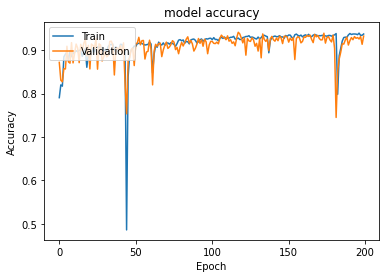

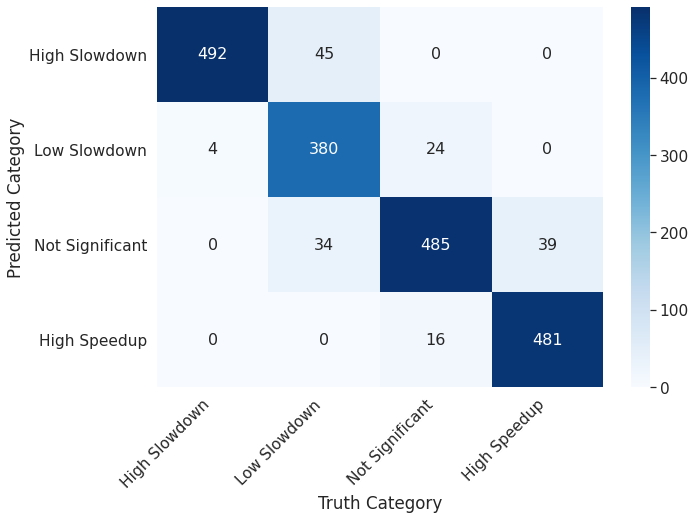

In [10]:
# Configuration information about training
config = {
    'input_data': './data/generated.size.cfgs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'generated_size.control',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 200,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels, fmt='g')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

In [11]:
results = []
results += eval_results_zeroing_llvm(model, [], features_test, graphs_test, y_test, description='Zeroing Nothing')
results += eval_results_zeroing_llvm(model, get_terminators(), features_test, graphs_test, y_test, description='Zeroing terminators')
results += eval_results_zeroing_llvm(model, get_unary(), features_test, graphs_test, y_test, description='Zeroing unaries')
results += eval_results_zeroing_llvm(model, get_binary(), features_test, graphs_test, y_test, description='Zeroing binaries')
results += eval_results_zeroing_llvm(model, get_memory(), features_test, graphs_test, y_test, description='Zeroing memories')
results += eval_results_zeroing_llvm(model, get_casts(), features_test, graphs_test, y_test, description='Zeroing casts')
results += eval_results_zeroing_llvm(model, get_others(), features_test, graphs_test, y_test, description='Zeroing others')
for i in range(0, len(llvm_codes)):
    results += eval_results_zeroing_llvm(model, [i], features_test, graphs_test, y_test, description=f'Zeroing {i}')
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 2, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 3, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 4, features_test, graphs_test, y_test)

Zeroing Nothing. loss: 0.5969921946525574, class_acc: 0.9190000295639038
Zeroing terminators. loss: 3.721562385559082, class_acc: 0.7164999842643738
Zeroing unaries. loss: 0.5997240543365479, class_acc: 0.9175000190734863
Zeroing binaries. loss: 1.1723334789276123, class_acc: 0.8424999713897705
Zeroing memories. loss: 11.411847114562988, class_acc: 0.6424999833106995
Zeroing casts. loss: 0.6740938425064087, class_acc: 0.9035000205039978
Zeroing others. loss: 1.2176648378372192, class_acc: 0.8385000228881836
Zeroing 0. loss: 11.544907569885254, class_acc: 0.8330000042915344
Zeroing 1. loss: 3.1774327754974365, class_acc: 0.703000009059906
Zeroing 2. loss: 0.5997751355171204, class_acc: 0.9190000295639038
Zeroing 3. loss: 0.597932755947113, class_acc: 0.9190000295639038
Zeroing 4. loss: 0.5969921946525574, class_acc: 0.9190000295639038
Zeroing 5. loss: 0.5969921946525574, class_acc: 0.9190000295639038
Zeroing 6. loss: 0.6230603456497192, class_acc: 0.9150000214576721
Zeroing 7. loss: 0.5

In [12]:
origin_eval_results = eval_results
results = []
for c in range(0, 150):
    zeroed_graphs = graphs_test.copy()
    edges_to_zero = [c]
    for i in range(0, zeroed_graphs.shape[0]):
        for j in range(0, zeroed_graphs.shape[1]):
            zero_edges(zeroed_graphs[i][j], edges_to_zero)

    eval_results = model.evaluate([features_test[:,0,:,:], zeroed_graphs[:,0,:,:], features_test[:,1,:,:], zeroed_graphs[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                          batch_size=config['batch_size'], verbose=0)
    results.append((edges_to_zero, eval_results[3], eval_results[3]/origin_eval_results[3]))
    print(f'Evaluation zeroing edges {edges_to_zero} (accuracy):{eval_results[3]}')    

Evaluation zeroing edges [0] (accuracy):0.8939999938011169
Evaluation zeroing edges [1] (accuracy):0.8964999914169312
Evaluation zeroing edges [2] (accuracy):0.8769999742507935
Evaluation zeroing edges [3] (accuracy):0.8794999718666077
Evaluation zeroing edges [4] (accuracy):0.8889999985694885
Evaluation zeroing edges [5] (accuracy):0.8999999761581421
Evaluation zeroing edges [6] (accuracy):0.8995000123977661
Evaluation zeroing edges [7] (accuracy):0.8980000019073486
Evaluation zeroing edges [8] (accuracy):0.8989999890327454
Evaluation zeroing edges [9] (accuracy):0.9045000076293945
Evaluation zeroing edges [10] (accuracy):0.8974999785423279
Evaluation zeroing edges [11] (accuracy):0.9020000100135803
Evaluation zeroing edges [12] (accuracy):0.906499981880188
Evaluation zeroing edges [13] (accuracy):0.8955000042915344
Evaluation zeroing edges [14] (accuracy):0.8949999809265137
Evaluation zeroing edges [15] (accuracy):0.906499981880188
Evaluation zeroing edges [16] (accuracy):0.907500028

# Training with CFG + Call graphs

Information saved to ./model_data/GNN_generated_size.control.call_150x150_1620189276.1427524/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/generated.size.cfgcs_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5002,
        Class B: 4999,
        Class C: 4999,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
inpu

16093

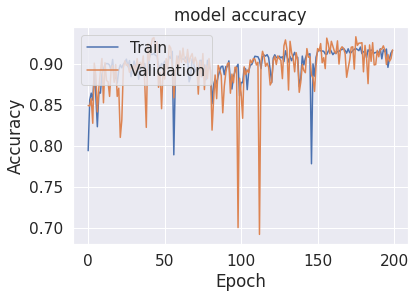

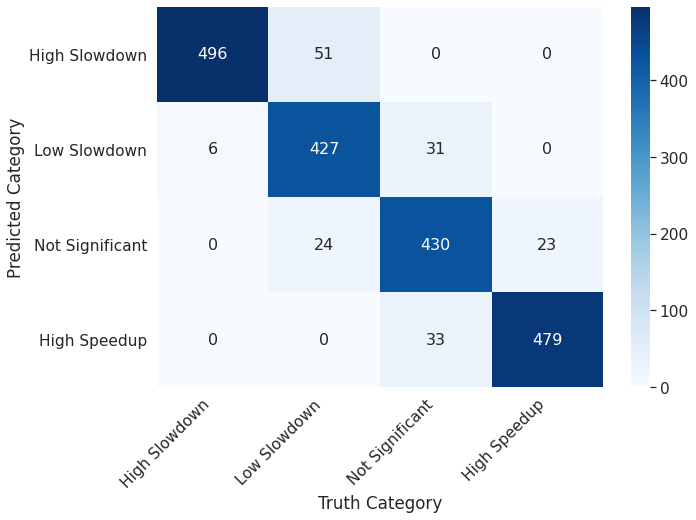

In [13]:
# Configuration information about training
config = {
    'input_data': './data/generated.size.cfgcs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'generated_size.control.call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 200,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file, transparent=False, bbox_inches='tight')
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels, fmt='g')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

In [14]:
results = []
results += eval_results_zeroing_llvm(model, [], features_test, graphs_test, y_test, description='Zeroing Nothing')
results += eval_results_zeroing_llvm(model, get_terminators(), features_test, graphs_test, y_test, description='Zeroing terminators')
results += eval_results_zeroing_llvm(model, get_unary(), features_test, graphs_test, y_test, description='Zeroing unaries')
results += eval_results_zeroing_llvm(model, get_binary(), features_test, graphs_test, y_test, description='Zeroing binaries')
results += eval_results_zeroing_llvm(model, get_memory(), features_test, graphs_test, y_test, description='Zeroing memories')
results += eval_results_zeroing_llvm(model, get_casts(), features_test, graphs_test, y_test, description='Zeroing casts')
results += eval_results_zeroing_llvm(model, get_others(), features_test, graphs_test, y_test, description='Zeroing others')
for i in range(0, len(llvm_codes)):
    results += eval_results_zeroing_llvm(model, [i], features_test, graphs_test, y_test, description=f'Zeroing {i}')
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 2, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 3, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 4, features_test, graphs_test, y_test)

Zeroing Nothing. loss: 0.7116021513938904, class_acc: 0.9160000085830688
Zeroing terminators. loss: 1.8724439144134521, class_acc: 0.7875000238418579
Zeroing unaries. loss: 0.7125333547592163, class_acc: 0.9160000085830688
Zeroing binaries. loss: 0.9308260679244995, class_acc: 0.8644999861717224
Zeroing memories. loss: 5.701503276824951, class_acc: 0.6000000238418579
Zeroing casts. loss: 0.7617514133453369, class_acc: 0.8974999785423279
Zeroing others. loss: 1.910516381263733, class_acc: 0.7544999718666077
Zeroing 0. loss: 0.9258641600608826, class_acc: 0.890500009059906
Zeroing 1. loss: 1.6753050088882446, class_acc: 0.7994999885559082
Zeroing 2. loss: 0.7124190330505371, class_acc: 0.9150000214576721
Zeroing 3. loss: 0.7114390730857849, class_acc: 0.9164999723434448
Zeroing 4. loss: 0.7116021513938904, class_acc: 0.9160000085830688
Zeroing 5. loss: 0.7116021513938904, class_acc: 0.9160000085830688
Zeroing 6. loss: 0.7284793257713318, class_acc: 0.9135000109672546
Zeroing 7. loss: 0.7

In [15]:
origin_eval_results = eval_results
results = []
for c in range(0, 150):
    zeroed_graphs = graphs_test.copy()
    edges_to_zero = [c]
    for i in range(0, zeroed_graphs.shape[0]):
        for j in range(0, zeroed_graphs.shape[1]):
            zero_edges(zeroed_graphs[i][j], edges_to_zero)

    eval_results = model.evaluate([features_test[:,0,:,:], zeroed_graphs[:,0,:,:], features_test[:,1,:,:], zeroed_graphs[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                          batch_size=config['batch_size'], verbose=0)
    results.append((edges_to_zero, eval_results[3], eval_results[3]/origin_eval_results[3]))
    print(f'Evaluation zeroing edges {edges_to_zero} (accuracy):{eval_results[3]}')    

Evaluation zeroing edges [0] (accuracy):0.8980000019073486
Evaluation zeroing edges [1] (accuracy):0.9010000228881836
Evaluation zeroing edges [2] (accuracy):0.8859999775886536
Evaluation zeroing edges [3] (accuracy):0.8934999704360962
Evaluation zeroing edges [4] (accuracy):0.8939999938011169
Evaluation zeroing edges [5] (accuracy):0.9020000100135803
Evaluation zeroing edges [6] (accuracy):0.9035000205039978
Evaluation zeroing edges [7] (accuracy):0.9089999794960022
Evaluation zeroing edges [8] (accuracy):0.906499981880188
Evaluation zeroing edges [9] (accuracy):0.9085000157356262
Evaluation zeroing edges [10] (accuracy):0.8955000042915344
Evaluation zeroing edges [11] (accuracy):0.9024999737739563
Evaluation zeroing edges [12] (accuracy):0.9024999737739563
Evaluation zeroing edges [13] (accuracy):0.902999997138977
Evaluation zeroing edges [14] (accuracy):0.9085000157356262
Evaluation zeroing edges [15] (accuracy):0.9004999995231628
Evaluation zeroing edges [16] (accuracy):0.901499986

# Train With CFG + Data Edges

Information saved to ./model_data/GNN_generated_size.control.data_150x150_1620190529.4664607/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/generated.size.cdfgs_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5002,
        Class B: 4998,
        Class C: 5000,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
inpu

16050

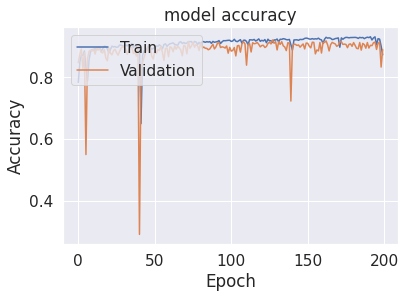

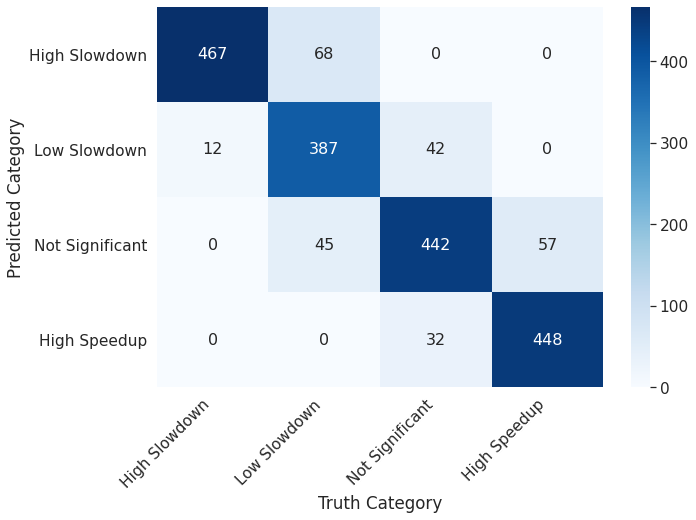

In [16]:
# Configuration information about training
config = {
    'input_data': './data/generated.size.cdfgs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'generated_size.control.data',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 200,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels, fmt='g')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

In [17]:
results = []
results += eval_results_zeroing_llvm(model, [], features_test, graphs_test, y_test, description='Zeroing Nothing')
results += eval_results_zeroing_llvm(model, get_terminators(), features_test, graphs_test, y_test, description='Zeroing terminators')
results += eval_results_zeroing_llvm(model, get_unary(), features_test, graphs_test, y_test, description='Zeroing unaries')
results += eval_results_zeroing_llvm(model, get_binary(), features_test, graphs_test, y_test, description='Zeroing binaries')
results += eval_results_zeroing_llvm(model, get_memory(), features_test, graphs_test, y_test, description='Zeroing memories')
results += eval_results_zeroing_llvm(model, get_casts(), features_test, graphs_test, y_test, description='Zeroing casts')
results += eval_results_zeroing_llvm(model, get_others(), features_test, graphs_test, y_test, description='Zeroing others')
for i in range(0, len(llvm_codes)):
    results += eval_results_zeroing_llvm(model, [i], features_test, graphs_test, y_test, description=f'Zeroing {i}')
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 2, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 3, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 4, features_test, graphs_test, y_test)

Zeroing Nothing. loss: 0.8396056294441223, class_acc: 0.871999979019165
Zeroing terminators. loss: 2.191882848739624, class_acc: 0.7245000004768372
Zeroing unaries. loss: 0.8424748778343201, class_acc: 0.8694999814033508
Zeroing binaries. loss: 1.0975960493087769, class_acc: 0.8115000128746033
Zeroing memories. loss: 2.470552682876587, class_acc: 0.6389999985694885
Zeroing casts. loss: 0.8824915885925293, class_acc: 0.8514999747276306
Zeroing others. loss: 1.1994876861572266, class_acc: 0.7850000262260437
Zeroing 0. loss: 1.0422182083129883, class_acc: 0.8345000147819519
Zeroing 1. loss: 2.6790237426757812, class_acc: 0.7379999756813049
Zeroing 2. loss: 0.8396456837654114, class_acc: 0.871999979019165
Zeroing 3. loss: 0.8413265347480774, class_acc: 0.871999979019165
Zeroing 4. loss: 0.8396056294441223, class_acc: 0.871999979019165
Zeroing 5. loss: 0.8396056294441223, class_acc: 0.871999979019165
Zeroing 6. loss: 0.8598942756652832, class_acc: 0.8665000200271606
Zeroing 7. loss: 0.83960

In [18]:
origin_eval_results = eval_results
results = []
for c in range(0, 150):
    zeroed_graphs = graphs_test.copy()
    edges_to_zero = [c]
    for i in range(0, zeroed_graphs.shape[0]):
        for j in range(0, zeroed_graphs.shape[1]):
            zero_edges(zeroed_graphs[i][j], edges_to_zero)

    eval_results = model.evaluate([features_test[:,0,:,:], zeroed_graphs[:,0,:,:], features_test[:,1,:,:], zeroed_graphs[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                          batch_size=config['batch_size'], verbose=0)
    results.append((edges_to_zero, eval_results[3], eval_results[3]/origin_eval_results[3]))
    print(f'Evaluation zeroing edges {edges_to_zero} (accuracy):{eval_results[3]}')    

Evaluation zeroing edges [0] (accuracy):0.8424999713897705
Evaluation zeroing edges [1] (accuracy):0.8565000295639038
Evaluation zeroing edges [2] (accuracy):0.8420000076293945
Evaluation zeroing edges [3] (accuracy):0.8460000157356262
Evaluation zeroing edges [4] (accuracy):0.8525000214576721
Evaluation zeroing edges [5] (accuracy):0.8560000061988831
Evaluation zeroing edges [6] (accuracy):0.8604999780654907
Evaluation zeroing edges [7] (accuracy):0.8529999852180481
Evaluation zeroing edges [8] (accuracy):0.862500011920929
Evaluation zeroing edges [9] (accuracy):0.8610000014305115
Evaluation zeroing edges [10] (accuracy):0.8535000085830688
Evaluation zeroing edges [11] (accuracy):0.8554999828338623
Evaluation zeroing edges [12] (accuracy):0.8569999933242798
Evaluation zeroing edges [13] (accuracy):0.8550000190734863
Evaluation zeroing edges [14] (accuracy):0.8629999756813049
Evaluation zeroing edges [15] (accuracy):0.8539999723434448
Evaluation zeroing edges [16] (accuracy):0.86100000

# Train CFG + Call + Data Graphs

Information saved to ./model_data/GNN_generated_size.control.call.data_150x150_1620191781.1884708/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/generated.size.cdfgcs_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5000,
        Class B: 5000,
        Class C: 5000,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 67)]    0                                            
_________________________________________________________________________________________________

16099

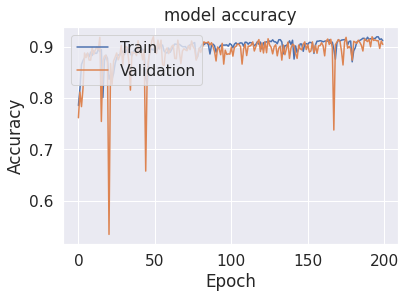

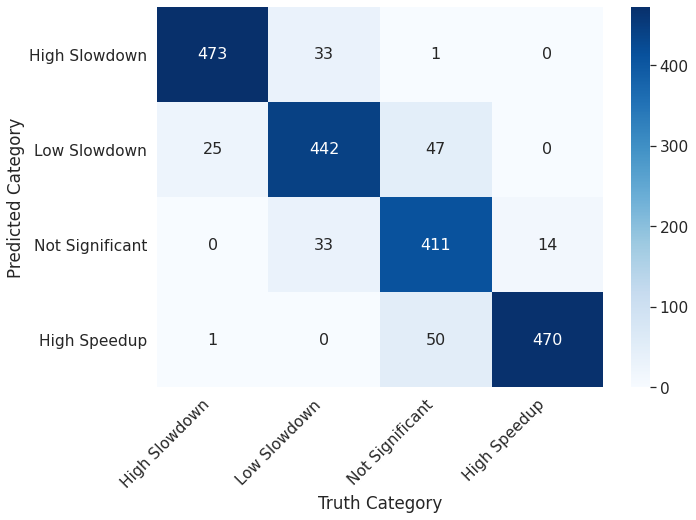

In [19]:
# Configuration information about training
config = {
    'input_data': './data/generated.size.cdfgcs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'generated_size.control.call.data',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 200,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels, fmt='g')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file, bbox_inches='tight')
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

In [20]:
results = []
results += eval_results_zeroing_llvm(model, [], features_test, graphs_test, y_test, description='Zeroing Nothing')
results += eval_results_zeroing_llvm(model, get_terminators(), features_test, graphs_test, y_test, description='Zeroing terminators')
results += eval_results_zeroing_llvm(model, get_unary(), features_test, graphs_test, y_test, description='Zeroing unaries')
results += eval_results_zeroing_llvm(model, get_binary(), features_test, graphs_test, y_test, description='Zeroing binaries')
results += eval_results_zeroing_llvm(model, get_memory(), features_test, graphs_test, y_test, description='Zeroing memories')
results += eval_results_zeroing_llvm(model, get_casts(), features_test, graphs_test, y_test, description='Zeroing casts')
results += eval_results_zeroing_llvm(model, get_others(), features_test, graphs_test, y_test, description='Zeroing others')
for i in range(0, len(llvm_codes)):
    results += eval_results_zeroing_llvm(model, [i], features_test, graphs_test, y_test, description=f'Zeroing {i}')
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 2, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 3, features_test, graphs_test, y_test)
for i in range (0, 50):
    results += eval_results_zeroing_llvm_random(model, 4, features_test, graphs_test, y_test)

Zeroing Nothing. loss: 0.8024381995201111, class_acc: 0.8980000019073486
Zeroing terminators. loss: 1.8469500541687012, class_acc: 0.7365000247955322
Zeroing unaries. loss: 0.8037204742431641, class_acc: 0.8974999785423279
Zeroing binaries. loss: 1.0954426527023315, class_acc: 0.8274999856948853
Zeroing memories. loss: 3.4225549697875977, class_acc: 0.6215000152587891
Zeroing casts. loss: 0.8899075388908386, class_acc: 0.8755000233650208
Zeroing others. loss: 1.6766198873519897, class_acc: 0.7885000109672546
Zeroing 0. loss: 0.9737624526023865, class_acc: 0.878000020980835
Zeroing 1. loss: 1.6798253059387207, class_acc: 0.7580000162124634
Zeroing 2. loss: 0.8026804327964783, class_acc: 0.8985000252723694
Zeroing 3. loss: 0.804198682308197, class_acc: 0.8974999785423279
Zeroing 4. loss: 0.8024381995201111, class_acc: 0.8980000019073486
Zeroing 5. loss: 0.8024381995201111, class_acc: 0.8980000019073486
Zeroing 6. loss: 0.8208362460136414, class_acc: 0.8899999856948853
Zeroing 7. loss: 0.

In [21]:
origin_eval_results = eval_results
results = []
for c in range(0, 150):
    zeroed_graphs = graphs_test.copy()
    edges_to_zero = [c]
    for i in range(0, zeroed_graphs.shape[0]):
        for j in range(0, zeroed_graphs.shape[1]):
            zero_edges(zeroed_graphs[i][j], edges_to_zero)

    eval_results = model.evaluate([features_test[:,0,:,:], zeroed_graphs[:,0,:,:], features_test[:,1,:,:], zeroed_graphs[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                          batch_size=config['batch_size'], verbose=0)
    results.append((edges_to_zero, eval_results[3], eval_results[3]/origin_eval_results[3]))
    print(f'Evaluation zeroing edges {edges_to_zero} (accuracy):{eval_results[3]}')    

Evaluation zeroing edges [0] (accuracy):0.8784999847412109
Evaluation zeroing edges [1] (accuracy):0.8845000267028809
Evaluation zeroing edges [2] (accuracy):0.8700000047683716
Evaluation zeroing edges [3] (accuracy):0.8805000185966492
Evaluation zeroing edges [4] (accuracy):0.878000020980835
Evaluation zeroing edges [5] (accuracy):0.887499988079071
Evaluation zeroing edges [6] (accuracy):0.8914999961853027
Evaluation zeroing edges [7] (accuracy):0.8859999775886536
Evaluation zeroing edges [8] (accuracy):0.8899999856948853
Evaluation zeroing edges [9] (accuracy):0.8955000042915344
Evaluation zeroing edges [10] (accuracy):0.8820000290870667
Evaluation zeroing edges [11] (accuracy):0.8769999742507935
Evaluation zeroing edges [12] (accuracy):0.8840000033378601
Evaluation zeroing edges [13] (accuracy):0.8889999985694885
Evaluation zeroing edges [14] (accuracy):0.8834999799728394
Evaluation zeroing edges [15] (accuracy):0.8859999775886536
Evaluation zeroing edges [16] (accuracy):0.888999998